Importing dependencies and loading the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('heart.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Making target y and input X and splitting the data with train_test_split method into training data and validation data.

In [4]:
categorical_columns = ['sex','cp','restecg','slp','thall']
numerical_columns = ['age','trtbps','chol','fbs','thalachh','exng','oldpeak','caa']

# X and y
X = df.drop('output', axis=1)

y = df['output']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Defining the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)])

# Fit transforming numerical data to standard scale and categorical data to one hot encoding.
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Defining search space for hyperparameters.

In [5]:
# Define the search space
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("col_sample_bytree", 0.5, 1),
    "random_state": 1,
    "seed": 0,
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
}

Defining method that uses XGBClassifier model and calculates the accuracy and returns it.

In [31]:
def get_parameters(space):

    # Defining the model
    model = xgb.XGBClassifier(**space)

    # Defining evaluation set
    eval_set = [(X_train, y_train), (X_test, y_test)]

    # Fitting the model
    model.fit(X_train, y_train, eval_set=eval_set, eval_metric="logloss", early_stopping_rounds=10, verbose=False)

    # Predicting
    y_pred = model.predict(X_test)
    
    # Calculating accuracy
    accuracy = accuracy_score(y_test, y_pred>0.5)

    print("Accuracy: {0}".format(accuracy))

    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

HyperOpt's Bayesian optimization algorithm tries to find the best hyperparameters for the XGBClassifier model.

In [32]:
trials = Trials()

# Run the hyperparameter search using the tpe algorithm
xgb_model_1_parameters = fmin(fn=get_parameters, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Accuracy: 0.7704918032786885                           
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7540983606557377                                                      
Accuracy: 0.7868852459016393                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7868852459016393                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7540983606557377                                                       
Accuracy: 0.7704918032786885  

Checking the best paramaters.

In [33]:
xgb_model_1 = trials.best_trial['result']['model']
print("The best model parameters are:\n ", xgb_model_1.get_xgb_params())
print("\nThe best model:")
print(xgb_model_1)

The best model parameters are:
  {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.651133544494133, 'eval_metric': None, 'gamma': 2.135472786217388, 'gpu_id': 0, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': 0.26236645756938426, 'max_bin': 475, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 9, 'max_leaves': None, 'min_child_weight': 1.0, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 1, 'reg_alpha': 0.2166891437568873, 'reg_lambda': 0.049811211117659515, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None, 'seed': 0}

The best model:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsamp

In [34]:
# Method returns accuracy of the model.
def test_models(model):
    eval_set = [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_metric="logloss", eval_set=eval_set, early_stopping_rounds=10, verbose=False)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred>0.5)
    print(f"Accuracy of the model: {accuracy}")
    return 

In [35]:
xgb_model_1_accuracy = test_models(xgb_model_1)
print(f"Accuracy of xgb_model_1: {xgb_model_1_accuracy}")

standard_model_accuracy = test_models(xgb.XGBClassifier())
print(f"Accuracy of standard_model: {standard_model_accuracy}")

Accuracy of xgb_model_1: 0.8032786885245902
Accuracy of standard_model: 0.7049180327868853


Checking feature importances.

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

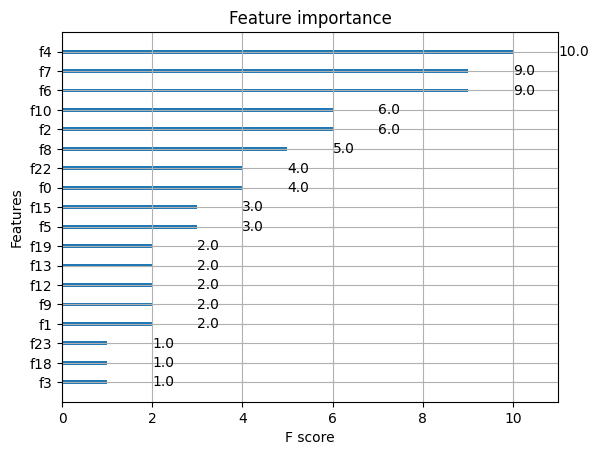

In [36]:
xgb.plot_importance(xgb_model_1)

In [37]:
# Method that plots the results of the XGBoost model, so that we can see if the model is underfitting or overfitting.
def plot_results(results):
    plt.plot(results["validation_0"]["logloss"], label="Train")
    plt.plot(results["validation_1"]["logloss"], label="Test")
    plt.legend()
    plt.show()

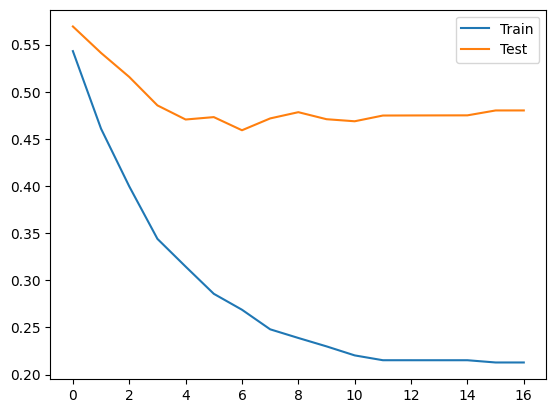

In [38]:
# Plotting the results of xgb_model_1.
results_1 = xgb_model_1.evals_result()
plot_results(results_1)

Fine tuning search space.

In [39]:
# max_depth range changed from 3-10 to 1-10
# "tree_method" added
# "gpu_id" added.
space = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 1000, 100)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': scope.int(hp.quniform('max_depth', 1, 10, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("col_sample_bytree", 0.5, 1),
    "random_state": 1,
    "seed": 0,
    "tree_method": "gpu_hist",
    "gpu_id": 0,
    "max_bin": scope.int(hp.quniform("max_bin", 100, 1000, 1)),
}

In [40]:
trials = Trials()
xgb_model_2_params = fmin(fn=get_parameters, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Accuracy: 0.7377049180327869                           
Accuracy: 0.7377049180327869                                                      
Accuracy: 0.7377049180327869                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7868852459016393                                                      
Accuracy: 0.7540983606557377                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7540983606557377                                                      
Accuracy: 0.7540983606557377                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7540983606557377                                                      
Accuracy: 0.8032786885245902                                                       
Accuracy: 0.7704918032786885  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7744143950763084, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=6.329850569373, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.21586538138473288, max_bin=406,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=0.0, missing=nan, monotone_constraints=None,
              n_estimators=800, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)
Xgb_model_2 accuracy: 0.8360655737704918


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

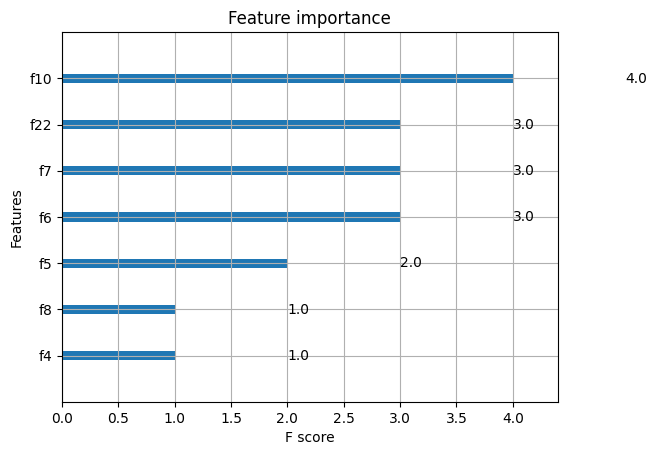

In [41]:
xgb_model_2 = trials.best_trial['result']['model']
print(xgb_model_2)
xgb_model_2_accuracy = test_models(xgb_model_2)
print(f"Xgb_model_2 accuracy: {xgb_model_2_accuracy}")
xgb.plot_importance(xgb_model_2)

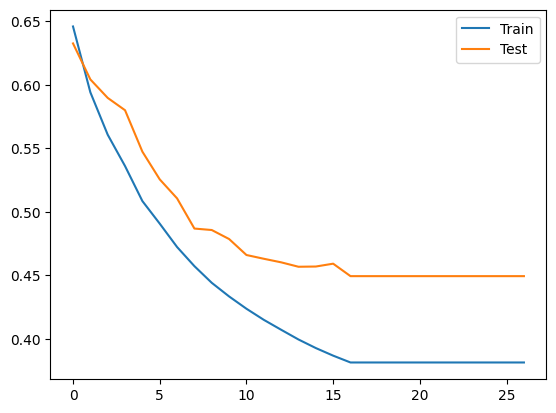

In [42]:
results_2 = xgb_model_2.evals_result()
plot_results(results_2)

Fine tuning search space again.

In [87]:
# max_depth range changed from 1-10 to 1
# min_child_weight range changed from 0-10 to 1-9 
# colsample_bytree range changed from 0.5-1 to 0-1
# "bgtree" booster added, max_bin changed from 100-1000 t0 250-500
# n_estimators changed from 100-1000 to 2500
# learning_rate changed from 0.01-0.3 to 0.05-0.25
# Added subsample 0.5-0.8
space = {
    "n_estimators": 2500,
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.25),
    'max_depth': 1,
    'min_child_weight': hp.quniform('min_child_weight', 1, 9, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    "reg_alpha": hp.uniform("reg_alpha", 0, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("col_sample_bytree", 0, 1),
    "subsample": hp.uniform("subsample", 0.5, 0.8),
    "random_state": 1,
    "seed": 0,
    "tree_method": "gpu_hist",
    "gpu_id": 0,
    "booster": "gbtree",
    "max_bin": scope.int(hp.quniform("max_bin", 250, 500, 1)),
}

In [88]:
trials = Trials()
xgb_model_3_params = fmin(fn=get_parameters, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

Accuracy: 0.7704918032786885                           
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7868852459016393                                                      
Accuracy: 0.7377049180327869                                                      
Accuracy: 0.8032786885245902                                                      
Accuracy: 0.7868852459016393                                                      
Accuracy: 0.8032786885245902                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.8032786885245902                                                      
Accuracy: 0.7704918032786885                                                      
Accuracy: 0.7377049180327869                                                       
Accuracy: 0.7704918032786885                                                       
Accuracy: 0.7868852459016393 

In [89]:
xgb_model_3 = trials.best_trial['result']['model']
print(xgb_model_3_params)
print("The best model is:\n")
print(xgb_model_3)

{'col_sample_bytree': 0.16577086375273176, 'gamma': 8.575993531215072, 'learning_rate': 0.23572792226064168, 'max_bin': 361.0, 'max_depth': 1.0, 'min_child_weight': 5.0, 'reg_alpha': 0.33219227501235205, 'reg_lambda': 0.2219836176557117, 'subsample': 0.6028817198243142}
The best model is:

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.16577086375273176, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=8.575993531215072, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23572792226064168, max_bin=361,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=5.0, missing=nan, monotone_constraints=None,
              n_estimators=

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

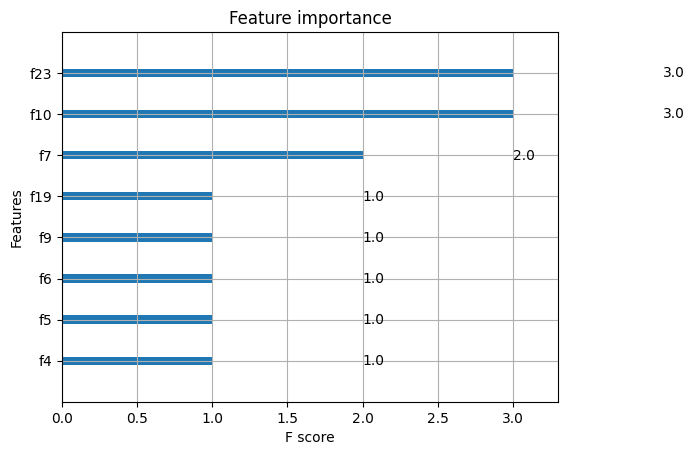

In [90]:
xgb_model_3.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric="logloss", early_stopping_rounds=10, verbose=False)
xgb.plot_importance(xgb_model_3)

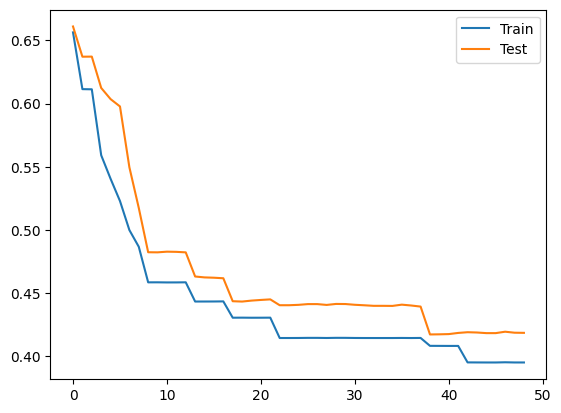

In [91]:
results_3 = xgb_model_3.evals_result()
plot_results(results_3)